# Saliency map for MNIST
First, we train on all of the MNIST data, and plot the saliency map (gradient and smooth gradient).
The result is a mess, and difficult to interpret.
Then, we will train on only the labels 0 and 1.
The result is much easier to interpret, as should be expected.
As a sanity check, we check that randomizing parameters in a trained model ruins the salinecy map.
## Use all labels

In [1]:
# setup environment
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from model import CNN
from train import train_model
from saliency import saliency, plot_saliency
device = torch.device('cuda' if torch.cuda.is_available() else torch.device('cpu'))
print(f'training on {device}')

training on cpu


In [2]:
# load and normalize image 
batch_size=128
train_mnist = datasets.MNIST('../MNIST_data', train=True, download=False,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_mnist = datasets.MNIST('../MNIST_data', train=False, download=False,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))
train_loader = torch.utils.data.DataLoader(
    train_mnist,
    batch_size=batch_size, shuffle=True,pin_memory=True) 
test_loader = torch.utils.data.DataLoader(
    test_mnist,
    batch_size=batch_size, shuffle=True, pin_memory=True)

In [3]:
# define model
model = CNN().to(device)

In [4]:
# train model
epochs=10
(loss_trn_list, loss_val_list, acc_trn_list, acc_val_list)=train_model(model,train_loader,test_loader, device, epochs=epochs)

percent of epochs completed: 100%|██████████| 10/10 [06:32<00:00, 39.29s/it]


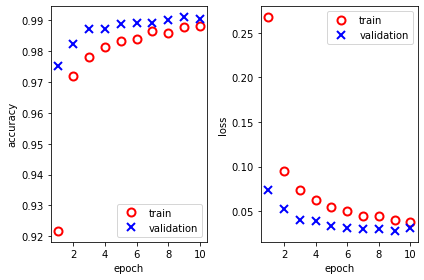

In [5]:
# plot performance
# note that during the training loop is followed by the validation loop
# this is why the validation loss is lower.
fig, ax = plt.subplots(1,2)
ax[0].plot(range(1,epochs+1),acc_trn_list,'or', fillstyle='none', markersize=8, markeredgewidth =2, label='train')
ax[0].plot(range(1,epochs+1),acc_val_list,'xb', markersize=8, markeredgewidth =2, label='validation')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('accuracy')
ax[0].legend()
ax[1].plot(range(1,epochs+1),loss_trn_list,'or', fillstyle='none', markersize=8, markeredgewidth =2, label='train')
ax[1].plot(range(1,epochs+1),loss_val_list,'xb', markersize=8, markeredgewidth =2, label='validation')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')
ax[1].legend()
plt.tight_layout()
plt.show()
fig.savefig('performance.png',format='png')

In [6]:
# get samples
for trn_batch in train_loader:
    sample_img, sample_label = trn_batch
    break
# Compute saliency
# N_smooth is the number of saliency maps we average over by adding Gaussian noise of zero mean.
# std: standard deviaction of noise (Gaussian)
# Note that when N_smooth = 0, we do not apply any noise
img_grad=saliency(model, sample_img, sample_label, device, N_smooth = 0)
img_grad_sm=saliency(model, sample_img, sample_label, device, N_smooth = 100, std=0.2)
img_grad_rand=saliency(model, sample_img, sample_label, device, N_smooth = 0, rand_ndx_list = [1])
img_grad_sm_rand=saliency(model, sample_img, sample_label, device, N_smooth = 100, std=0.2, rand_ndx_list = [1])

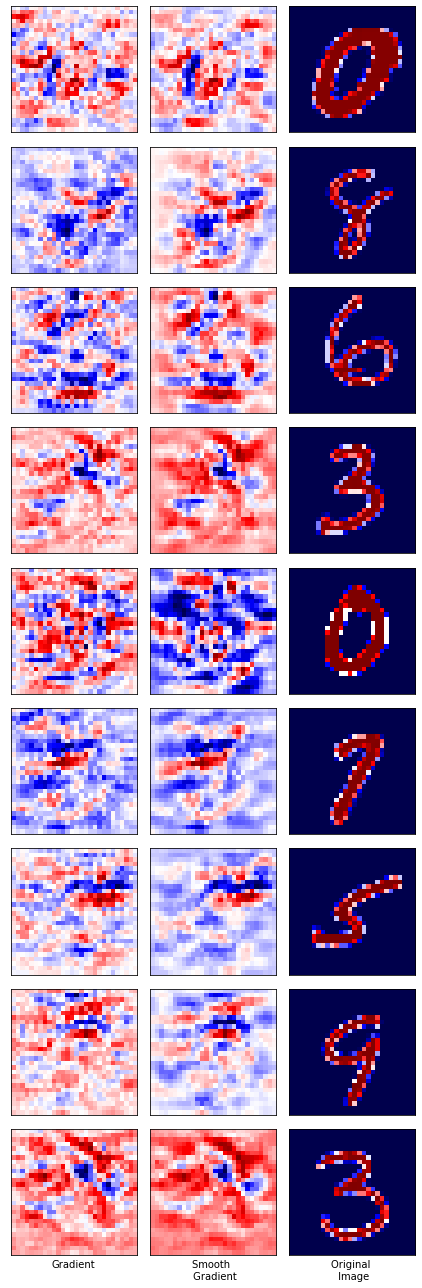

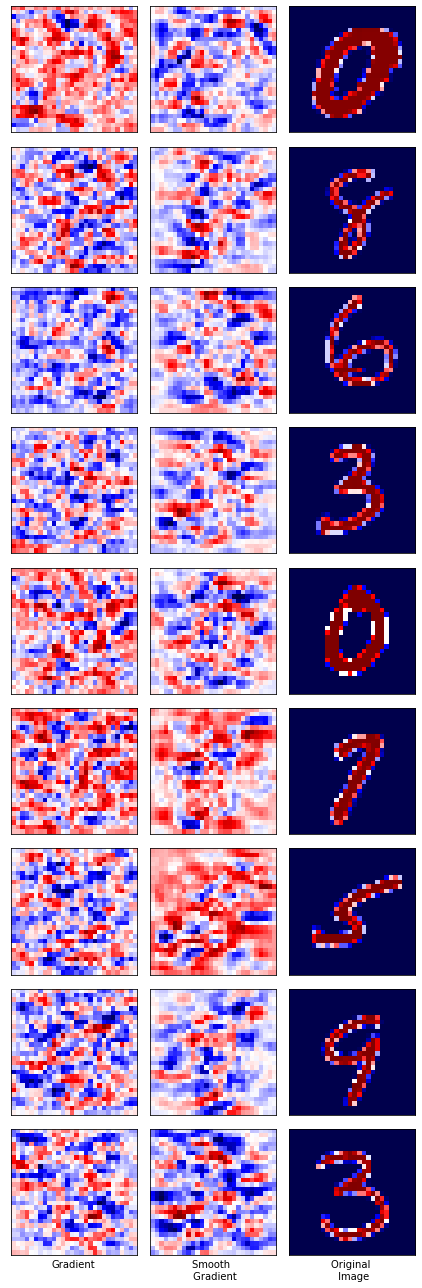

In [7]:
# plot saliency
# for gradients, red: positive, blue: negative
plot_saliency(9,img_grad, img_grad_sm, sample_img, 'saliency.png', cmap='seismic')
plot_saliency(9,img_grad_rand, img_grad_sm_rand, sample_img, 'saliency_rand.png',cmap='seismic')

# Restrict labels to 0 and 1

In [8]:
batch_size=128
train_mnist = datasets.MNIST('../MNIST_data', train=True, download=False,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_mnist = datasets.MNIST('../MNIST_data', train=False, download=False,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))
train_loader = torch.utils.data.DataLoader(
    train_mnist,
    batch_size=batch_size, shuffle=True,pin_memory=True) 
test_loader = torch.utils.data.DataLoader(
    test_mnist,
    batch_size=batch_size, shuffle=True, pin_memory=True)
# to select specific labels: https://stackoverflow.com/questions/57913825/how-to-select-specific-labels-in-pytorch-mnist-dataset
indices_train = (train_mnist.targets == 0) | (train_mnist.targets == 1) # if you want to keep images with the label 5
train_mnist.data, train_mnist.targets = train_mnist.data[indices_train], train_mnist.targets[indices_train]
indices_test = (test_mnist.targets == 0) | (test_mnist.targets == 1) # if you want to keep images with the label 5
test_mnist.data, test_mnist.targets = test_mnist.data[indices_test], test_mnist.targets[indices_test]

In [9]:
# define model
model = CNN(label_size=2).to(device)
# train model
epochs=10
(loss_trn_list, loss_val_list, acc_trn_list, acc_val_list)=train_model(model,train_loader,test_loader, device, epochs=epochs)

percent of epochs completed: 100%|██████████| 10/10 [01:22<00:00,  8.24s/it]


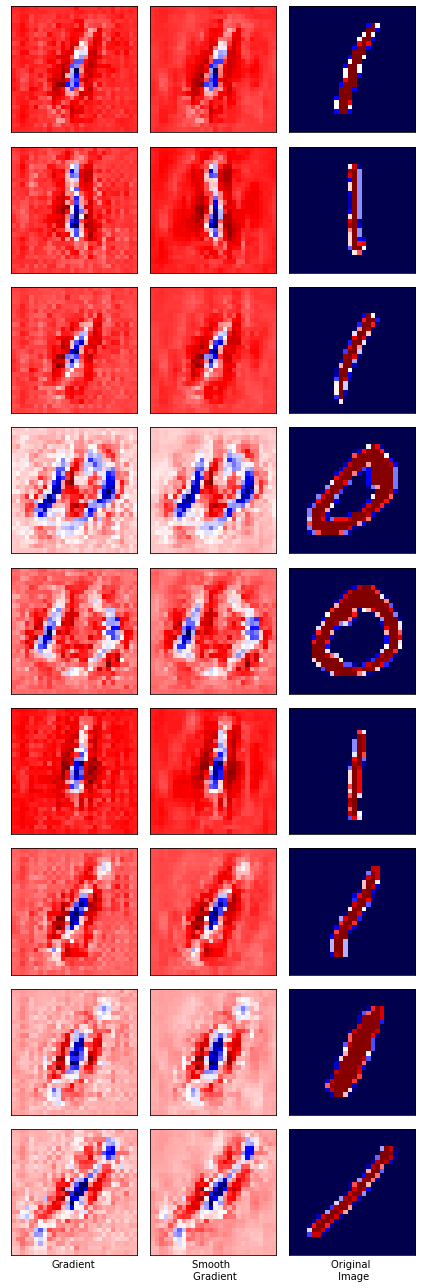

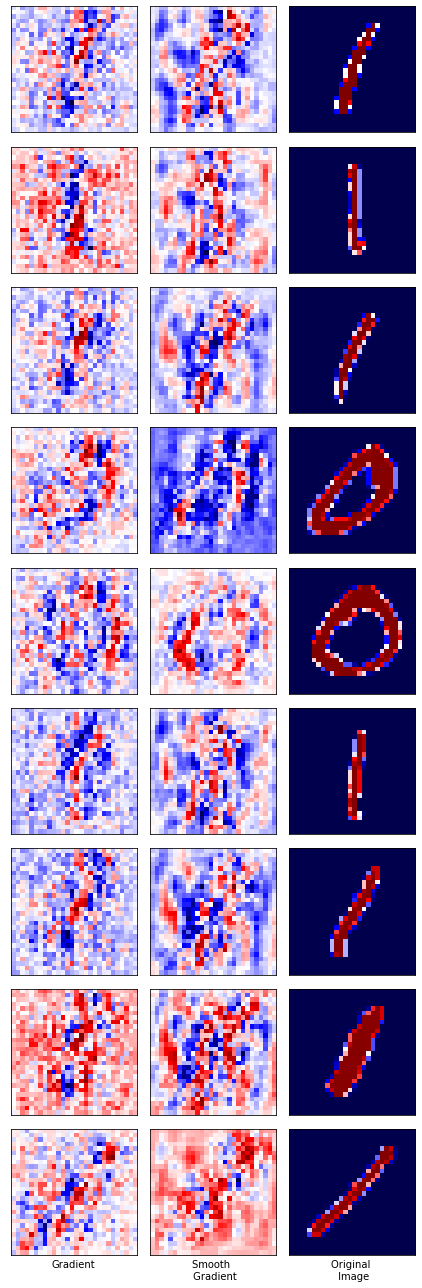

In [10]:
# get samples
for trn_batch in train_loader:
    sample_img, sample_label = trn_batch
    break
# Compute saliency
# N_smooth is the number of saliency maps we average over by adding Gaussian noise of zero mean.
# std: standard deviaction of noise (Gaussian)
# Note that when N_smooth = 0, we do not apply any noise
img_grad=saliency(model, sample_img, sample_label, device, N_smooth = 0)
img_grad_sm=saliency(model, sample_img, sample_label, device, N_smooth = 100, std=0.2)
img_grad_rand=saliency(model, sample_img, sample_label, device, N_smooth = 0, rand_ndx_list = [1])
img_grad_sm_rand=saliency(model, sample_img, sample_label, device, N_smooth = 100, std=0.2, rand_ndx_list = [1])
# plot saliency
# for gradients, red: positive, blue: negative
plot_saliency(9,img_grad, img_grad_sm, sample_img, 'saliency01.png', cmap='seismic')
plot_saliency(9,img_grad_rand, img_grad_sm_rand, sample_img, 'saliency_rand01.png',cmap='seismic')